# Project on sentiment analysis using NLP
## Brief info on sentiment analysis
Sentiment analysis is a natural language processing (NLP) technique that automatically identifies the polarity (positive, negative, or neutral) of a given text.

## Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLTK library-specifically for NLP tasks
import nltk
from nltk.corpus import stopwords  # stopwords are words in the text that do not affect the polarity of our sentiment
from nltk.stem import WordNetLemmatizer  # for lemmatization: change words to base form


# Wordcloud for vizualization and frequency of the occurence of words
from wordcloud import WordCloud

# download the stopwords and wordcloud
nltk.download('stopwords')
nltk.download('wordnet')

# Sklearn to do vectorization
from sklearn.feature_extraction.text import CountVectorizer

# we shall use the random forest classifier as our model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
!pip install scikit-plot

In [4]:
from scikitplot.metrics import plot_confusion_matrix

## Import the dataset

from: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=train.txt

In [8]:
# we shall use delimeter as semi-colon since the sentiment and the rest are seperated by ';'
# and use names as 'text' and 'labels' to avoid using the first row(which is a datapoint) as a column
df_train = pd.read_csv('/train.txt', delimiter=';', names=['text', 'label'])  # depends on where you have your dataset
df_val = pd.read_csv('/val.txt', delimiter=';', names=['text', 'label'])

In [9]:
df_train

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [10]:
df_val

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


### Merge validation data to the train data
we are concatenating the val.txt to the terain.txt and imprtantly we need to reset the index when doing so

In [11]:
df = pd.concat([df_train, df_val])
df.reset_index(inplace=True, drop=True)

In [12]:
df.tail()

,text,label
17995,im having ssa examination tomorrow in the morn...,sadness
17996,i constantly worry about their fight against n...,joy
17997,i feel its important to share this info for th...,joy
17998,i truly feel that if you are passionate enough...,joy
17999,i feel like i just wanna buy any cute make up ...,joy


In [13]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [14]:
df.shape

(18000, 2)

we have _18000_ rows and _2_ columns

In [15]:
df.label.unique()  # what are the reviews we had

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [16]:
df.label.value_counts()  # the reviews and their number of times we have in the dataset

,count
label,
joy,6066
sadness,5216
anger,2434
fear,2149
love,1482
surprise,653


<Axes: xlabel='label'>

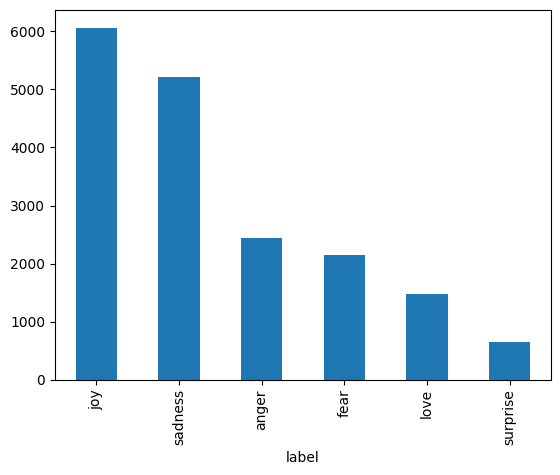

In [17]:
df.label.value_counts().plot.bar()

## Positive and Negative sentiment
We shall not use all the _6 reviews_ but rather classify all those reviews into _Positive_ and _negative_ sentiments

- Positive sentiments- Joy, Love, Surprise
- Negative sentiment- Anger, Sadness, Fear

With _Positive_ being _1_ and the _Negative sentiment_ as _0_

In [18]:

df['label'].replace(to_replace=['surprise', 'joy', 'love'], value=1, inplace=True)
df['label'].replace(to_replace=['anger', 'fear', 'sadness'], value=0, inplace=True)

<ipython-input-18-9b05028eb9e7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace(to_replace=['surprise', 'joy', 'love'], value=1, inplace=True)
<ipython-input-18-9b05028eb9e7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'].replace(to_replace=['anger', 'fear', 'sadne

In [19]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0
...,...,...
17995,im having ssa examination tomorrow in the morn...,0
17996,i constantly worry about their fight against n...,1
17997,i feel its important to share this info for th...,1
17998,i truly feel that if you are passionate enough...,1


<Axes: xlabel='label'>

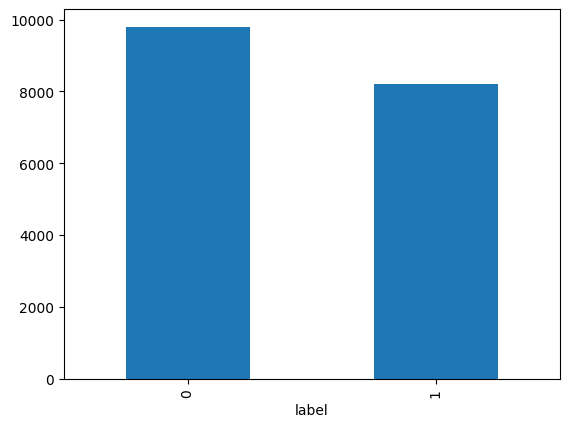

In [20]:
df.label.value_counts().plot.bar()

## Preprocessing

- Get rid of all characters that are NOT alphabets
- remove the stop words
- Lemmatization

In [21]:
lm = WordNetLemmatizer()

In [22]:
def transorm_alph(df_column):
  output = []
  for i in df_column:
    new_text = re.sub('[^a-zA-z]', ' ', str(i))
    new_text = new_text.lower()
    new_text = new_text.split()
    new_text = [lm.lemmatize(j) for j in new_text if j not in set(stopwords.words('english'))]
    output.append(' '.join(str(k) for k in new_text))  # convert new_text from list of words into a string of words

  return output


In [23]:
# test the function to do our pre-processing
var = transorm_alph(df.text)

In [24]:
# check its result
var

['didnt feel humiliated',
 'go feeling hopeless damned hopeful around someone care awake',
 'im grabbing minute post feel greedy wrong',
 'ever feeling nostalgic fireplace know still property',
 'feeling grouchy',
 'ive feeling little burdened lately wasnt sure',
 'ive taking milligram time recommended amount ive fallen asleep lot faster also feel like funny',
 'feel confused life teenager jaded year old man',
 'petronas year feel petronas performed well made huge profit',
 'feel romantic',
 'feel like make suffering seeing mean something',
 'feel running divine experience expect type spiritual encounter',
 'think easiest time year feel dissatisfied',
 'feel low energy thirsty',
 'immense sympathy general point possible proto writer trying find time write corner life sign agent let alone publishing contract feel little precious',
 'feel reassured anxiety side',
 'didnt really feel embarrassed',
 'feel pretty pathetic time',
 'started feeling sentimental doll child began collection vint

**For more accurate results , we could use _advanced lemmitization_**

## Wordcloud

In [25]:
plt.figure(figsize=(20, 8))
word = ''
for i in var:
  for j in i:
    word += " ".join(j)

<Figure size 2000x800 with 0 Axes>

In [26]:
word

'didnt feel humiliatedgo feeling hopeless damned hopeful around someone care awakeim grabbing minute post feel greedy wrongever feeling nostalgic fireplace know still propertyfeeling grouchyive feeling little burdened lately wasnt sureive taking milligram time recommended amount ive fallen asleep lot faster also feel like funnyfeel confused life teenager jaded year old manpetronas year feel petronas performed well made huge profitfeel romanticfeel like make suffering seeing mean somethingfeel running divine experience expect type spiritual encounterthink easiest time year feel dissatisfiedfeel low energy thirstyimmense sympathy general point possible proto writer trying find time write corner life sign agent let alone publishing contract feel little preciousfeel reassured anxiety sidedidnt really feel embarrassedfeel pretty pathetic timestarted feeling sentimental doll child began collection vintage barbie doll sixtyfeel compromised skeptical value every unit work putfeel irritated rej

**All the text from var is combined into one cloud of single text**

In [27]:
from wordcloud import WordCloud

In [28]:
wc = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(word)

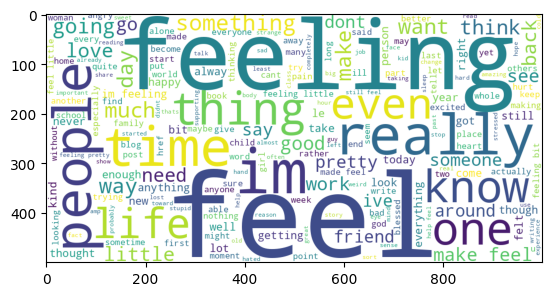

In [29]:
plt.imshow(wc)

**From the above we can see that some words like: _feeling_ they are not in their base form yet, concluding that using 'WordNetLemmatizer' is not _100%_ thus need of _advanced word lemmatizers_**

## Bag of Words(BOW)

In [30]:
cv = CountVectorizer(ngram_range=(1,2))
train_data = cv.fit_transform(var)
X_train = train_data
y_train = df.label

In [31]:
X_train

<18000x117594 sparse matrix of type '<class 'numpy.int64'>'
	with 311217 stored elements in Compressed Sparse Row format>

## Using RandomForestClassifier Model
### Training

In [32]:
model = RandomForestClassifier()

In [33]:
# Hyperparameter tuning

parameters = {'max_features':('auto', 'sqrt'),
              'n_estimators': [500, 1000, 1500],
              'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5, 10],
              'min_samples_split': [5, 10, 15],
              'bootstrap': [True, False]}

In [34]:
parameters

{'max_features': ('auto', 'sqrt'),
 'n_estimators': [500, 1000, 1500],
 'max_depth': [5, 10, None],
 'min_samples_leaf': [1, 2, 5, 10],
 'min_samples_split': [5, 10, 15],
 'bootstrap': [True, False]}

In [35]:
grid_search = GridSearchCV(model, parameters,
                           cv=5,
                           return_train_score=True,
                           n_jobs=1)

In [36]:
# grid_search.fit(X_train, y_train)

In [37]:
# grid_search.best_params_

In [38]:
# a model with the best parameters chosen
rfc = RandomForestClassifier()

In [39]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

### Testing

In [40]:
df_test = pd.read_csv('/test.txt', delimiter=';', names=['text', 'label'])  # depends on where you have your dataset



In [41]:
df_test

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [43]:
df_test.label.unique()

array(['sadness', 'joy', 'fear', 'anger', 'love', 'surprise'],
      dtype=object)

<Axes: xlabel='label'>

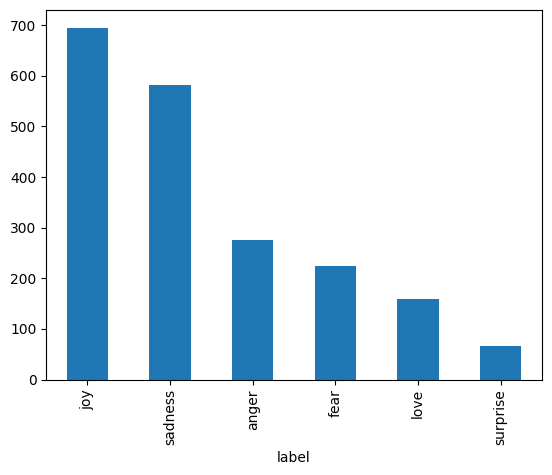

In [44]:
df_test.label.value_counts().plot.bar()

In [45]:
df_test['label'].replace(to_replace=['surprise', 'joy', 'love'], value=1, inplace=True)
df_test['label'].replace(to_replace=['anger', 'fear', 'sadness'], value=0, inplace=True)

<ipython-input-45-49b73046e350>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['label'].replace(to_replace=['anger', 'fear', 'sadness'], value=0, inplace=True)


<Axes: xlabel='label'>

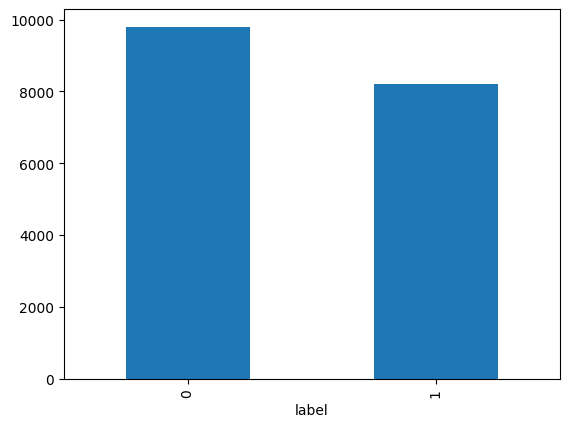

In [46]:
df.label.value_counts().plot.bar()

In [47]:
var_test = transorm_alph(df_test.text)

In [48]:
var_test

['im feeling rather rotten im ambitious right',
 'im updating blog feel shitty',
 'never make separate ever want feel like ashamed',
 'left bouquet red yellow tulip arm feeling slightly optimistic arrived',
 'feeling little vain one',
 'cant walk shop anywhere feel uncomfortable',
 'felt anger end telephone call',
 'explain clung relationship boy many way immature uncommitted despite excitement feeling getting accepted master program university virginia',
 'like breathless feeling reader eager see happen next',
 'jest feel grumpy tired pre menstrual probably week im fit walrus vacation summer',
 'feel particularly agitated',
 'feel beautifully emotional knowing woman knew handful holding baba journey',
 'pay attention deepens feeling invaded helpless',
 'feel extremely comfortable group people dont even need hide',
 'find odd position feeling supportive',
 'feeling heartbroken im sure katniss',
 'feel little mellow today',
 'feel like role would tear sail pessimism discontent',
 'feel 

In [49]:
plt.figure(figsize=(20, 8))
word_test = ''
for i in var_test:
  for j in i:
    word_test += " ".join(j)

<Figure size 2000x800 with 0 Axes>

In [50]:
word_test

'im feeling rather rotten im ambitious rightim updating blog feel shittynever make separate ever want feel like ashamedleft bouquet red yellow tulip arm feeling slightly optimistic arrivedfeeling little vain onecant walk shop anywhere feel uncomfortablefelt anger end telephone callexplain clung relationship boy many way immature uncommitted despite excitement feeling getting accepted master program university virginialike breathless feeling reader eager see happen nextjest feel grumpy tired pre menstrual probably week im fit walrus vacation summerfeel particularly agitatedfeel beautifully emotional knowing woman knew handful holding baba journeypay attention deepens feeling invaded helplessfeel extremely comfortable group people dont even need hidefind odd position feeling supportivefeeling heartbroken im sure katnissfeel little mellow todayfeel like role would tear sail pessimism discontentfeel bcoz fight get mad n u wanna make publicity n let world know fightfeel like red purple rich

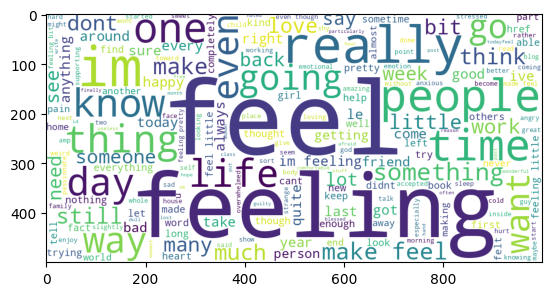

In [51]:
wc_test = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(word_test)
plt.imshow(wc_test)

In [60]:
test_data = cv.transform(var_test)  # use the already fitted CountVectorizer from the training phase
X_test = test_data

In [61]:
y_test = df_test.label

## Model evaluation

## Testing with Custom Input

In [63]:
# Fit the CountVectorizer ONLY on the training data
cv = CountVectorizer(ngram_range=(1,2))
X_train = cv.fit_transform(var)  # fit_transform on training data only

# Train the RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# For testing data, use ONLY transform (NOT fit_transform) with the same CountVectorizer
var_test = transorm_alph(df_test.text)
X_test = cv.transform(var_test)  # transform using the vocabulary learned from training data
y_test = df_test.label

# Now, for custom input, do the same:
def sentiment_analysis(user_input):
    # Wrap the input in a list and preprocess
    new_input = transorm_alph([user_input])

    # Transform the input using the same CountVectorizer
    transformed_input = cv.transform(new_input)

    # Make the prediction
    prediction = rfc.predict(transformed_input)

    # Output the result
    if prediction == 0:
        print('This is a NEGATIVE sentiment')
    elif prediction == 1:
        print('This is a POSITIVE sentiment')
    else:
        print("Neutral sentiment")

# Get user input and perform sentiment analysis
usr_input = "I am in too much vain and agony"
sentiment_analysis(usr_input)


This is a NEGATIVE sentiment


In [64]:
custom_input = input("Enter a sentence: ")
sentiment_analysis(custom_input)

Enter a sentence: I am so happy and excited today! Everything is going perfectly, and I couldn't ask for a better day!
This is a POSITIVE sentiment


In [66]:
custom_input = input("Enter a sentence: ")
sentiment_analysis(custom_input)

Enter a sentence: I feel so sad and down today. Everything seems to be going wrong, and it's really hard to stay positive.
This is a NEGATIVE sentiment


In [67]:
custom_input = input("Enter a sentence: ")
sentiment_analysis(custom_input)

Enter a sentence: I'm really frustrated and angry with the way things turned out. This is absolutely unacceptable!
This is a NEGATIVE sentiment


## Model Evaluation

In [68]:
# First, make predictions on the test set
y_pred = rfc.predict(X_test)  # X_test is the transformed test data

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

In [69]:
print(f"Accuracy: ~{accuracy * 100:.3f}%")

Accuracy: ~96.350%
